<a href="https://colab.research.google.com/github/Cardinal14/DS_ML_port/blob/main/Siamese_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q torch_snippets
from torch_snippets import *
!wget -q https://www.dropbox.com/s/ua1rr8btkmpqjxh/face-detection.zip
!unzip -q face-detection.zip
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     |████████████████████████████████| 36.7MB 81kB/s 
     |████████████████████████████████| 61kB 10.6MB/s 
     |████████████████████████████████| 102kB 14.0MB/s 


In [2]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, folder, transform=None, should_invert=True):
        self.folder = folder
        self.items = Glob(f'{self.folder}/*/*') 
        self.transform = transform
    def __getitem__(self, ix):
        itemA = self.items[ix]
        person = fname(parent(itemA))
        same_person = randint(2)
        if same_person:
            itemB = choose(Glob(f'{self.folder}/{person}/*', silent=True))
        else:
            while True:
                itemB = choose(self.items)
                if person != fname(parent(itemB)):
                    break
        imgA = read(itemA)
        imgB = read(itemB)
        if self.transform:
            imgA = self.transform(imgA)
            imgB = self.transform(imgB)
        return imgA, imgB, np.array([1-same_person])
    def __len__(self):
        return len(self.items)


In [3]:
from torchvision import transforms

trn_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(5, (0.01,0.2),
                            scale=(0.9,1.1)),
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

val_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trn_ds = SiameseNetworkDataset(folder="./data/faces/training/", transform=trn_tfms)
val_ds = SiameseNetworkDataset(folder="./data/faces/testing/", transform=val_tfms)

trn_dl = DataLoader(trn_ds, shuffle=True, batch_size=64)
val_dl = DataLoader(val_ds, shuffle=False, batch_size=64)

2020-12-05 18:41:23.492 | INFO     | torch_snippets.loader:Glob:190 - 370 files found at ./data/faces/training//*/*
2020-12-05 18:41:23.494 | INFO     | torch_snippets.loader:Glob:190 - 30 files found at ./data/faces/testing//*/*


In [4]:
def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1, padding_mode='reflect'),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
    )

In [5]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.features = nn.Sequential(
            convBlock(1,4),
            convBlock(4,8),
            convBlock(8,8),
            nn.Flatten(),
            nn.Linear(8*100*100, 500), nn.ReLU(inplace=True),
            nn.Linear(500, 500), nn.ReLU(inplace=True),
            nn.Linear(500, 5)
        )

    def forward(self, input1, input2):
        output1 = self.features(input1)
        output2 = self.features(input2)
        return output1, output2

In [6]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        acc = ((euclidean_distance > 0.6) == label).float().mean()
        return loss_contrastive, acc

In [7]:
def train_batch(model, data, optimizer, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    optimizer.zero_grad()
    codesA, codesB = model(imgsA, imgsB)
    loss, acc = criterion(codesA, codesB, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    codesA, codesB = model(imgsA, imgsB)
    loss, acc = criterion(codesA, codesB, labels)
    return loss.item(), acc.item()

In [8]:
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

In [9]:
n_epochs = 200
log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(trn_dl)
    for i, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(epoch+(1+i)/N, trn_loss=loss, trn_acc=acc, end='\r')
    N = len(val_dl)
    for i, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(epoch+(1+i)/N, val_loss=loss, val_acc=acc, end='\r')
    if (epoch+1)%20==0: log.report_avgs(epoch+1)
    if epoch==10: optimizer = optim.Adam(model.parameters(), lr=0.0005)

EPOCH: 20.000	trn_loss: 0.638	trn_acc: 0.665	val_loss: 0.649	val_acc: 0.600	(17.19s - 154.69s remaining)
EPOCH: 40.000	trn_loss: 0.513	trn_acc: 0.678	val_loss: 0.369	val_acc: 0.633	(34.44s - 137.75s remaining)
EPOCH: 60.000	trn_loss: 0.390	trn_acc: 0.786	val_loss: 0.129	val_acc: 0.900	(51.61s - 120.42s remaining)
EPOCH: 80.000	trn_loss: 0.353	trn_acc: 0.790	val_loss: 0.138	val_acc: 0.900	(68.90s - 103.36s remaining)
EPOCH: 100.000	trn_loss: 0.246	trn_acc: 0.841	val_loss: 0.113	val_acc: 0.900	(85.99s - 85.99s remaining)
EPOCH: 120.000	trn_loss: 0.276	trn_acc: 0.830	val_loss: 0.293	val_acc: 0.667	(103.04s - 68.69s remaining)
EPOCH: 140.000	trn_loss: 0.244	trn_acc: 0.878	val_loss: 0.042	val_acc: 0.967	(120.46s - 51.62s remaining)
EPOCH: 160.000	trn_loss: 0.232	trn_acc: 0.864	val_loss: 0.106	val_acc: 0.933	(138.24s - 34.56s remaining)
EPOCH: 180.000	trn_loss: 0.213	trn_acc: 0.917	val_loss: 0.156	val_acc: 0.900	(155.78s - 17.31s remaining)
EPOCH: 200.000	trn_loss: 0.169	trn_acc: 0.925	val_l

  0%|          | 0/201 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 201/201 [00:00<00:00, 6168.82it/s]


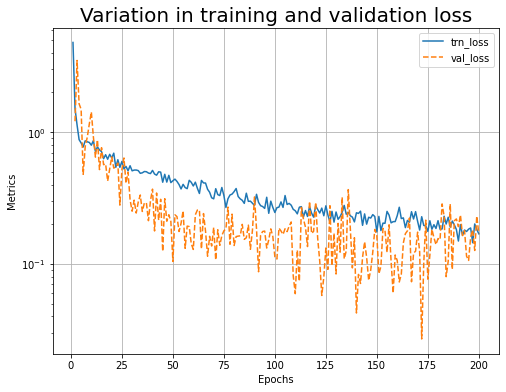

100%|██████████| 201/201 [00:00<00:00, 6980.49it/s]


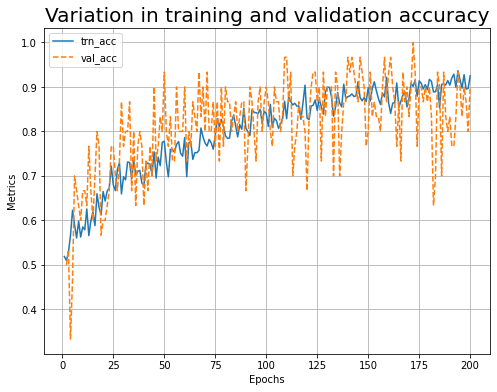

In [10]:
log.plot_epochs(['trn_loss', 'val_loss'], log=True, title='Variation in training and validation loss')
log.plot_epochs(['trn_acc', 'val_acc'], title='Variation in training and validation accuracy')

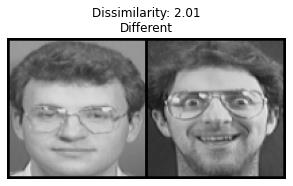

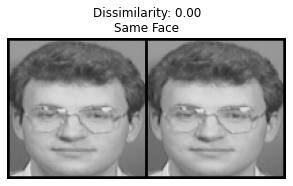

In [11]:
model.eval()
val_dl = DataLoader(val_ds,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(val_dl)
x0, _, _ = next(dataiter)

for i in range(2):
    _, x1, label2 = next(dataiter)
    concatenated = torch.cat((x0*0.5+0.5, x1*0.5+0.5),0)
    output1,output2 = model(x0.cuda(),x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    output = 'Same Face' if euclidean_distance.item() < 0.6 else 'Different'
    show(torchvision.utils.make_grid(concatenated),
         title='Dissimilarity: {:.2f}\n{}'.format(euclidean_distance.item(), output))
    plt.show()